The goal here is to evaluate the errors introduced adversarial training by a analyzing the added noise

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [4]:
origWeights = np.load('origWeights.npy', allow_pickle=True)
modifiedWeights = np.load('modifiedWeights.npy', allow_pickle=True)
origBiases = np.load('origBiases.npy', allow_pickle=True)
modifiedBiases = np.load('modifiedBiases.npy', allow_pickle=True)

In [5]:
def compute_minAndMax(listArrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    minVal = np.inf
    maxVal = -np.inf
    for arr in listArrays:
        if arr.min() < minVal:
            minVal = arr.min()
        if arr.max() > maxVal:
            maxVal = arr.max()
    return minVal, maxVal

In [6]:
def measure_noise(origValues, modifiedValues):
    noiseValues = []
    for origArr, modifiedArr in zip(origValues, modifiedValues):
        # error_arr is the element-wise difference of all values in the array
        errorArr = origArr - modifiedArr
        noiseValues.append(errorArr)
    return noiseValues

In [7]:
# mnist images are grayscale, so the depth is 1. In cifar10, depth is 3.
# The first 5 layers are convolutional layers in case of cifar10 while 
# only the first 3 are in case of mnist.
if origWeights[0].shape[2] == 1:
    numConvLayers = 3
else:
    numConvLayers = 5
modelNoise = measure_noise(origWeights[:numConvLayers], modifiedWeights)
convNoise = modelNoise[:numConvLayers]
min_noise, max_noise = compute_minAndMax(convNoise)
print(min_noise, max_noise)

-0.0020789653 0.0029890053


In [11]:
for layer in convNoise:
    print(layer.T.shape)
allMatrices = []
colors = []
if numConvLayers == 3:
    color = ['r', 'g', 'b']
else:
    color = ['r', 'g', 'b', 'y', 'c']

for layer,c in zip(convNoise,color):
    for filter in layer.T:
        for matrix in filter:
            allMatrices.append(matrix.flatten())
            colors.append(c)
allMatrices_tsne = TSNE(n_components=2, perplexity=100, n_iter=1200).fit_transform(allMatrices)
print(allMatrices_tsne.shape)

(32, 1, 3, 3)
(64, 32, 3, 3)
(64, 64, 3, 3)


NameError: name 'allMatrices_tsne' is not defined

Text(0.5, 1.0, 'Model Noise')

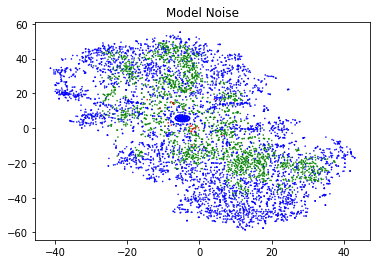

In [7]:
allMatrices_x, allMatrices_y = allMatrices_tsne.T
#plt.figure(figsize=(20,20))
plt.scatter(allMatrices_x, allMatrices_y, s=0.3, c=colors)
plt.title('Model Noise')

In [12]:
# Code to isolate the circular pattern from the plot
# Using 4 threshold values, I isolate the rectangular 
# region of the plot which contains the circular pattern
x_range = (-7,-2)
y_range = (3,9)
indices = (allMatrices_x < x_range[1]) * (allMatrices_y < y_range[1]) * \
(allMatrices_x > x_range[0]) * (allMatrices_y > y_range[0])

# Plot the isolated pattern to verify that circular pattern 
# was correctly isolated
colors = np.array(colors)
plt.scatter(allMatrices_x[indices], allMatrices_y[indices], c = colors[indices], s=2)
for idx in nonZeroPatternIndices:
    plt.plot(allMatrices_x[idx], allMatrices_y[idx], 'ro', markersize=4)
plt.title('Model Noise')

NameError: name 'allMatrices_x' is not defined

In [16]:
len(np.nonzero(indices)[0])

134

In [17]:
patternIndices = np.nonzero(indices)[0]
print(patternIndices)

[2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093
 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107
 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121
 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135
 2136 2137 2138 2139 2140 2141 2142 2143 2537 2576 2727 2768 3744 3745
 3746 3747 3748 3749 3750 3751 3752 3753 3754 3755 3756 3757 3758 3759
 3760 3761 3762 3763 3764 3765 3766 3767 3768 3769 3770 3771 3772 3773
 3774 3775 3776 3777 3778 3779 3780 3781 3782 3783 3784 3785 3786 3787
 3788 3789 3790 3791 3792 3793 3794 3795 3796 3797 3798 3799 3800 3801
 3802 3803 3804 3805 3806 3807 3993 5431]


In [18]:
nonZeroPatternIndices =[]
for idx in np.nditer(patternIndices):
    if (allMatrices[idx] != 0).any():
        nonZeroPatternIndices.append(idx)
        print(idx)

2537
2576
2727
3993
5431


In [22]:
allMatrices[2576]

array([ 0.0000000e+00,  0.0000000e+00, -1.3746903e-06,  0.0000000e+00,
        0.0000000e+00,  6.9476664e-07,  0.0000000e+00,  0.0000000e+00,
        7.1525574e-07], dtype=float32)

In [8]:
# Plot the random noise
randNoise = []
for layer in convNoise:
    randLayer = (max_noise - min_noise) * np.random.random(layer.shape)
    randNoise.append(randLayer)
randMatrices = []
for layer in randNoise:
    for filter in layer.T:
        for matrix in filter:
            randMatrices.append(matrix.flatten())
randMatricesTsne = TSNE(n_components=2, perplexity=100, n_iter=1200).fit_transform(randMatrices)
randMatrices_x, randMatrices_y = randMatricesTsne.T
plt.scatter(randMatrices_x, randMatrices_y, s=0.3, c=colors)
plt.title('Random Noise')

NameError: name 'realMatrices_x' is not defined

In [1]:
# Compute random noise for all of the layers in the same shape as the neural network weights.
def compute_realNoiseTsne(modelNoise, k = 0.01):
    realNoise = []
    for layer in modelNoise:
        randLayer = (max_noise - min_noise) * np.random.random(layer.shape)
        realLayer = layer + k*randLayer
        realNoise.append(realLayer)
    return realNoise

def compute_Tsne(realNoise):
    realMatrices = []
    for layer in realNoise:
        for filter in layer.T:
            for matrix in filter:
                realMatrices.append(matrix.flatten())
    realMatricesTsne = TSNE(n_components=2, perplexity=100, n_iter=1200).fit_transform(realMatrices)
    return realMatricesTsne

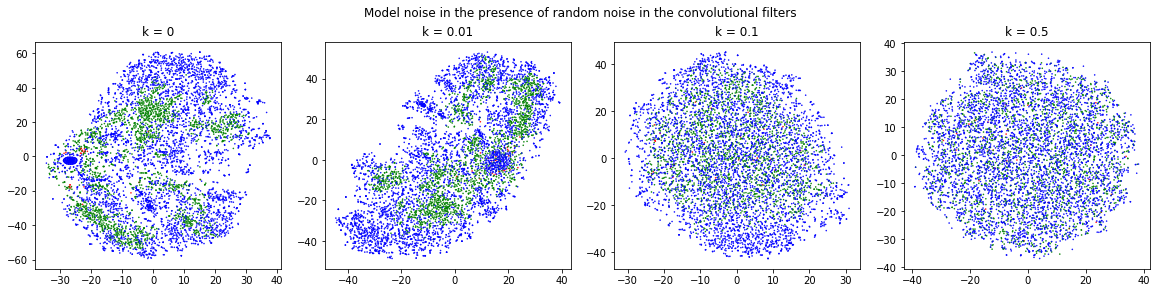

In [53]:
noiseValues = [0, 0.01, 0.1, 0.5]
numplots = len(noiseValues)
f, axarr = plt.subplots(1, numplots, figsize=(16,4), constrained_layout=True)
f.suptitle('Model noise in the presence of random noise in the convolutional filters')
for pltIdx, k in enumerate(noiseValues):
    realNoise = compute_realNoiseTsne(convNoise, k)
    realMatricesTsne = compute_Tsne(realNoise)
    realMatrices_x, realMatrices_y = realMatricesTsne.T
    axarr[pltIdx].scatter(realMatrices_x, realMatrices_y, s=0.3, c=colors)
    axarr[pltIdx].set(title='k = {}'.format(k))

In [25]:
allRandom = []
for i in range(6176):
    randomFilter = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    allRandom.append(randomFilter.flatten())
#allRandom_tsne = TSNE(n_components=2, perplexity=40, n_iter=1200).fit_transform(allRandom)

Text(0.5, 1.0, 'Random Noise')

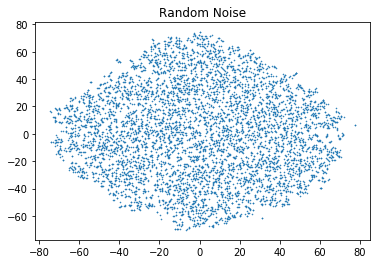

In [26]:
allRandom_x, allRandom_y = allRandom_tsne.T
plt.scatter(allRandom_x, allRandom_y, s=0.3)
plt.title('Random Noise')

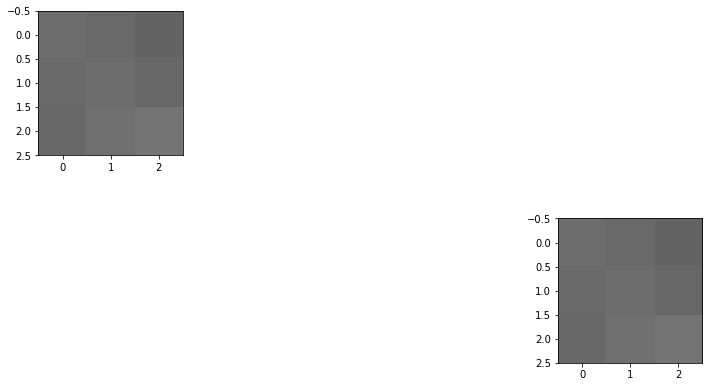

In [27]:
H = np.transpose(r[2])
#f, axarr = plt.subplots(2,5, figsize=(15,7))
#for num in range(7):
#    axarr[num//5][num%5].imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
f = plt.figure(figsize=(15,7))
ax = f.add_subplot(2,5,9)
ax1 = f.add_subplot(2,5,1)
num = 3
ax.imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
ax1.imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()

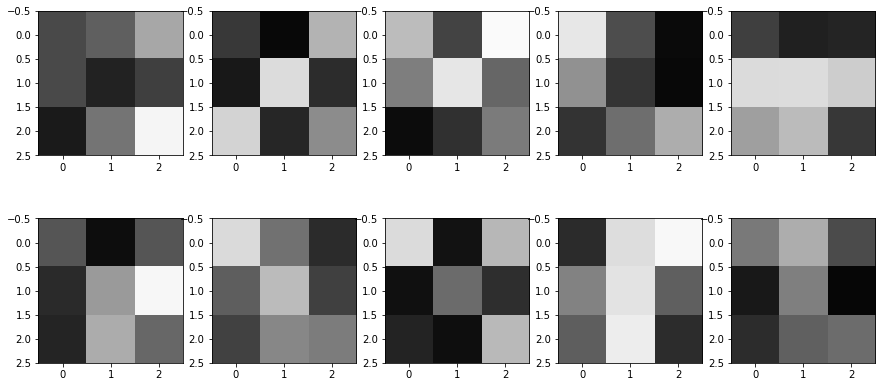

In [28]:
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    H = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    axarr.ravel()[num].imshow(H, cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()